In [1]:
# ============================================
# 0. CONFIG
# ============================================
CSV_PATH = "ai4i2020.csv"      # 연습용 CSV (ai4i2020)
TARGET_COL = "Tool_wear_min"   # 회귀 타깃

ID_COL = "UDI"                 # ID 컬럼
ID_LIKE_COLS = ["Product_ID"]  # 사실상 ID인 문자열 컬럼들 (피처에서 제거)

CATEGORICAL_COLS = ["Type"]    # 범주형 컬럼들 (다른 데이터셋에선 여기만 바꾸면 됨)

RANDOM_STATE = 42
TEST_SIZE = 0.2                # train/valid 분할 비율


In [2]:
# ============================================
# 1. IMPORTS
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
pd.set_option("display.max_columns", 100)


In [3]:
# ============================================
# 2. 데이터 로드 + 컬럼 이름 정리 + 기본 EDA
# ============================================
df_raw = pd.read_csv(CSV_PATH)

print("=== Raw Shape ===", df_raw.shape)
display(df_raw.head())
print(df_raw.info())
print("\n=== Raw Missing values ===")
print(df_raw.isnull().sum())

def clean_column_name(col: str) -> str:
    return (
        col.strip()
           .replace(" ", "_")
           .replace("[", "")
           .replace("]", "")
           .replace("(", "")
           .replace(")", "")
           .replace("/", "_")
           .replace("%", "pct")
           .replace("<", "lt")
           .replace(">", "gt")
    )

df = df_raw.copy()
df.columns = [clean_column_name(c) for c in df.columns]

print("\n=== Cleaned columns ===")
print(df.columns.tolist())


=== Raw Shape === (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)


=== Target(Tool_wear_min) 통계 ===


,Tool_wear_min
count,10000.000000
mean,107.951000
std,63.654147
min,0.000000
25%,53.000000
50%,108.000000
75%,162.000000
max,253.000000


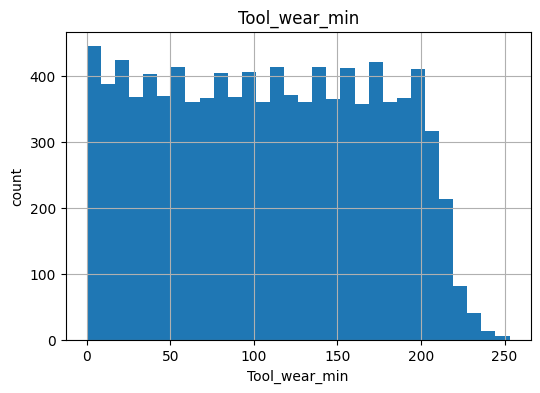

In [4]:
# 타깃 기본 통계/분포
print(f"\n=== Target({TARGET_COL}) 통계 ===")
display(df[TARGET_COL].describe())

df[TARGET_COL].hist(bins=30)
plt.title(TARGET_COL)
plt.xlabel(TARGET_COL)
plt.ylabel("count")
plt.show()


In [5]:
# ============================================
# 3. 범주형 / 수치형 분리 + 결측/이상치 탐지
# ============================================
# 타깃/ID/ID-like 제외 피처
feature_cols = [c for c in df.columns if c not in [TARGET_COL, ID_COL] + ID_LIKE_COLS]

X_full = df[feature_cols].copy()
y_full = df[TARGET_COL].copy()

# dtype 기반 자동 분리
cat_cols_auto = X_full.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_auto = X_full.select_dtypes(include=[np.number]).columns.tolist()

# CONFIG에서 지정한 범주형도 포함
cat_cols = sorted(set(cat_cols_auto) | set(c for c in CATEGORICAL_COLS if c in X_full.columns))
num_cols = num_cols_auto  # 진짜 숫자 컬럼만

print("범주형 컬럼:", cat_cols)
print("수치형 컬럼:", num_cols)

print("\n=== 결측치 개수 (수치형) ===")
print(X_full[num_cols].isnull().sum())

print("\n=== 결측치 개수 (범주형) ===")
print(X_full[cat_cols].isnull().sum())


범주형 컬럼: ['Type']
수치형 컬럼: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

=== 결측치 개수 (수치형) ===
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Machine_failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64

=== 결측치 개수 (범주형) ===
Type    0
dtype: int64


In [6]:
# IQR 기반 이상치 개수 확인
def detect_outliers_iqr(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).sum()

print("\n=== 이상치 개수(IQR 기준) ===")
for col in num_cols:
    n_out = detect_outliers_iqr(X_full[col])
    print(f"{col}: {n_out}")



=== 이상치 개수(IQR 기준) ===
Air_temperature_K: 0
Process_temperature_K: 0
Rotational_speed_rpm: 418
Torque_Nm: 69
Machine_failure: 339
TWF: 46
HDF: 115
PWF: 95
OSF: 98
RNF: 19


In [8]:
# ============================================
# 4. 전처리
#   - 결측치 처리
#   - 이상치 클리핑
#   - 수치형 스케일링
#   - 범주형 원-핫 인코딩
#   - PCA latent feature
# ============================================

# 4-1) 결측치 처리
X_num = X_full[num_cols].copy()
X_cat = X_full[cat_cols].copy()

# 수치형: median
X_num_imputed = X_num.fillna(X_num.median())

# 범주형: "Unknown"
X_cat_imputed = X_cat.fillna("Unknown")

# 4-2) 이상치 처리: 1% ~ 99% 구간 클리핑
for col in num_cols:
    lower = X_num_imputed[col].quantile(0.01)
    upper = X_num_imputed[col].quantile(0.99)
    X_num_imputed[col] = X_num_imputed[col].clip(lower, upper)

# 4-3) 수치형 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_imputed),
    columns=num_cols,
    index=X_num_imputed.index,
)

# 4-4) 범주형 원-핫 인코딩
X_cat_oh = pd.get_dummies(X_cat_imputed, columns=cat_cols, drop_first=True)

print("X_num_scaled shape:", X_num_scaled.shape)
print("X_cat_oh shape:", X_cat_oh.shape)


X_num_scaled shape: (10000, 10)
X_cat_oh shape: (10000, 2)


In [9]:
# 4-5) 비지도 PCA latent feature (수치형 기반)
if len(num_cols) > 0:
    n_components = min(3, len(num_cols))  # 수치형이 적으면 그만큼만
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_components = pca.fit_transform(X_num_scaled)

    X_pca = pd.DataFrame(
        pca_components,
        columns=[f"pca_{i+1}" for i in range(n_components)],
        index=X_num_scaled.index,
    )

    print("PCA explained variance ratio:", pca.explained_variance_ratio_)
    print("X_pca shape:", X_pca.shape)
else:
    X_pca = pd.DataFrame(index=X_num_scaled.index)
    print("수치형 피처가 없어서 PCA 스킵")

# 4-6) 최종 피처 결합
X_all = pd.concat([X_num_scaled, X_cat_oh, X_pca], axis=1)
print("최종 피처 shape:", X_all.shape)


PCA explained variance ratio: [0.34450308 0.31810792 0.22917748]
X_pca shape: (10000, 3)
최종 피처 shape: (10000, 15)


In [10]:
# ============================================
# 5. train/valid 분할
# ============================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_full,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("\n=== y_train 통계 ===")
display(y_train.describe())
print("\n=== y_valid 통계 ===")
display(y_valid.describe())


X_train shape: (8000, 15)
X_valid shape: (2000, 15)

=== y_train 통계 ===


,Tool_wear_min
count,8000.000000
mean,108.068750
std,63.225052
min,0.000000
25%,53.000000
50%,108.000000
75%,162.000000
max,253.000000



=== y_valid 통계 ===


,Tool_wear_min
count,2000.000000
mean,107.480000
std,65.356364
min,0.000000
25%,50.000000
50%,107.000000
75%,165.000000
max,246.000000


In [11]:
# ============================================
# 5. train/valid 분할
# ============================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_full,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("\n=== y_train 통계 ===")
display(y_train.describe())
print("\n=== y_valid 통계 ===")
display(y_valid.describe())


X_train shape: (8000, 15)
X_valid shape: (2000, 15)

=== y_train 통계 ===


,Tool_wear_min
count,8000.000000
mean,108.068750
std,63.225052
min,0.000000
25%,53.000000
50%,108.000000
75%,162.000000
max,253.000000



=== y_valid 통계 ===


,Tool_wear_min
count,2000.000000
mean,107.480000
std,65.356364
min,0.000000
25%,50.000000
50%,107.000000
75%,165.000000
max,246.000000


In [13]:
# ============================================
# 6. 회귀 평가 함수 (MAE, RMSE, R^2)
# ============================================
def eval_regressor(y_true, y_pred, print_report=True):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    if print_report:
        print("MAE :", mae)
        print("RMSE:", rmse)
        print("R^2 :", r2)

    return {"mae": mae, "rmse": rmse, "r2": r2}


In [14]:
# ============================================
# 7. 모델 학습
#   - LinearRegression
#   - RandomForestRegressor
#   - XGBRegressor
# ============================================

# 7-1) Linear Regression
print("=== LinearRegression ===")
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_valid)
metrics_lr = eval_regressor(y_valid, y_pred_lr)


=== LinearRegression ===
MAE : 56.16092651809455
RMSE: 64.78467170484586
R^2 : 0.01692656811682869


In [15]:
# 7-2) RandomForestRegressor
print("\n=== RandomForestRegressor ===")
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_valid)
metrics_rf = eval_regressor(y_valid, y_pred_rf)



=== RandomForestRegressor ===
MAE : 52.230769249999994
RMSE: 63.07112354357414
R^2 : 0.06824320277976159


In [16]:
# 7-3) XGBRegressor
print("\n=== XGBRegressor ===")
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_valid)
metrics_xgb = eval_regressor(y_valid, y_pred_xgb)



=== XGBRegressor ===
MAE : 53.25535202026367
RMSE: 62.77722501408253
R^2 : 0.07690656185150146


In [17]:
# ============================================
# 8. 만능 리포트 함수 (Regression 버전)
#   - 상위 p% / 상위 N개 / threshold
#   - 그룹별도 가능 (예: Type별)
# ============================================
def make_rank_report(
    df,                  # 원본 df (검증셋 인덱스로 필터된 상태)
    score,               # 예측값/리스크 score (회귀: 예측값 그대로 사용 가능)
    id_cols,             # 항상 보고 싶은 ID 컬럼들
    extra_cols=None,     # 추가로 보고 싶은 컬럼들
    k_ratio=None,        # 상위 비율 (예: 0.05)
    k_abs=None,          # 상위 개수 (예: 100)
    threshold=None,      # score threshold (예: 200 이상인 샘플만)
    group_col=None,      # 그룹별 (예: 'Type')
    max_rows=30          # 최종 출력 최대 행 수
):
    """
    Regression에서도 'pred가 큰 상위 x%'를 고위험 샘플로 본다고 가정하고
    랭킹 리포트를 만드는 함수.
    """

    tmp = df.copy()
    tmp["score"] = score

    base_cols = list(id_cols)
    if extra_cols is not None:
        base_cols += list(extra_cols)
    base_cols = [c for c in base_cols if c in tmp.columns] + ["score"]

    # ---- 1) 그룹별 리포트 ----
    if group_col is not None and group_col in tmp.columns:
        reports = []
        for g, g_df in tmp.groupby(group_col):
            g_sorted = g_df.sort_values("score", ascending=False)

            if threshold is not None:
                g_sel = g_sorted[g_sorted["score"] >= threshold]
            elif k_abs is not None:
                g_sel = g_sorted.head(k_abs)
            elif k_ratio is not None:
                k = max(1, int(len(g_sorted) * k_ratio))
                g_sel = g_sorted.head(k)
            else:
                g_sel = g_sorted.head(max_rows)

            g_sel = g_sel[base_cols].head(max_rows)
            g_sel[group_col] = g
            reports.append(g_sel)

        if len(reports) == 0:
            return pd.DataFrame(columns=base_cols + [group_col])

        report_df = pd.concat(reports, axis=0)
        report_df = report_df.sort_values("score", ascending=False)
        return report_df.head(max_rows)

    # ---- 2) 전체 기준 리포트 ----
    tmp_sorted = tmp.sort_values("score", ascending=False)

    if threshold is not None:
        sel = tmp_sorted[tmp_sorted["score"] >= threshold]
    elif k_abs is not None:
        sel = tmp_sorted.head(k_abs)
    elif k_ratio is not None:
        k = max(1, int(len(tmp_sorted) * k_ratio))
        sel = tmp_sorted.head(k)
    else:
        sel = tmp_sorted.head(max_rows)

    return sel[base_cols].head(max_rows)


In [18]:
# ============================================
# 9. 리포트 예시 1: 예측값 상위 5% (최대 30건)
#    - Tool_wear_min 값이 큰 것 = 고위험이라고 가정
# ============================================
valid_index = X_valid.index
df_valid = df.loc[valid_index].copy()

report_top5 = make_rank_report(
    df=df_valid,
    score=y_pred_xgb,    # XGBRegressor 예측값
    id_cols=[ID_COL],
    extra_cols=["Type", TARGET_COL],
    k_ratio=0.05,        # 상위 5%
    max_rows=30
)

print("=== XGBRegressor: 예측값 상위 5% (최대 30건) 리포트 ===")
display(report_top5)


=== XGBRegressor: 예측값 상위 5% (최대 30건) 리포트 ===


,UDI,Type,Tool_wear_min,score
9018,9019,L,217,226.540329
3019,3020,L,207,214.246445
1087,1088,H,206,206.972672
586,587,L,222,205.753052
6478,6479,L,145,204.956558
1595,1596,L,218,200.737488
6759,6760,L,208,200.251892
4816,4817,L,215,199.116547
1162,1163,L,202,194.791245
248,249,L,216,194.436661


In [19]:
# ============================================
# 10. 리포트 예시 2: threshold 기반 (예: 예측 Tool_wear >= 200)
# ============================================
threshold_value = 200  # 예시값, 실제 데이터 보고 알맞게 조정

report_th = make_rank_report(
    df=df_valid,
    score=y_pred_xgb,
    id_cols=[ID_COL],
    extra_cols=["Type", TARGET_COL],
    threshold=threshold_value,
    max_rows=50
)

print(f"=== XGBRegressor: 예측값 >= {threshold_value} (최대 50건) 리포트 ===")
display(report_th)


=== XGBRegressor: 예측값 >= 200 (최대 50건) 리포트 ===


,UDI,Type,Tool_wear_min,score
9018,9019,L,217,226.540329
3019,3020,L,207,214.246445
1087,1088,H,206,206.972672
586,587,L,222,205.753052
6478,6479,L,145,204.956558
1595,1596,L,218,200.737488
6759,6760,L,208,200.251892


In [20]:
# ============================================
# 11. SHAP으로 XGB 회귀 모델 해석
#    (트리 기반 회귀 모델 feature importance + 방향성)
# ============================================
!pip install shap -q
import shap

shap.initjs()


In [21]:
# 검증셋 일부 샘플링 (계산량 줄이기)
X_valid_df = X_valid.copy()

X_valid_sample = X_valid_df.sample(
    n=min(500, len(X_valid_df)),
    random_state=RANDOM_STATE
)

print("X_valid_sample shape:", X_valid_sample.shape)


X_valid_sample shape: (500, 15)


In [22]:
# TreeExplainer로 SHAP 값 계산
explainer_reg = shap.TreeExplainer(xgb_reg)
shap_values_reg = explainer_reg.shap_values(X_valid_sample)

print("shap_values_reg shape:", np.array(shap_values_reg).shape)


shap_values_reg shape: (500, 15)


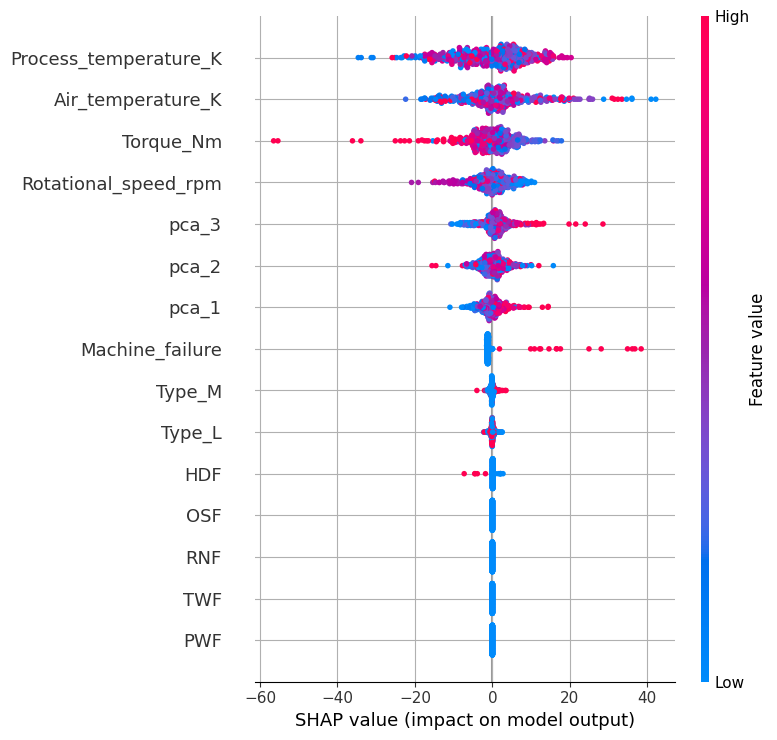

In [23]:
# Summary plot: 어떤 피처가 회귀값에 영향을 많이 주는지 + 방향성
shap.summary_plot(
    shap_values_reg,
    X_valid_sample,
    feature_names=X_valid_sample.columns,
    show=True
)


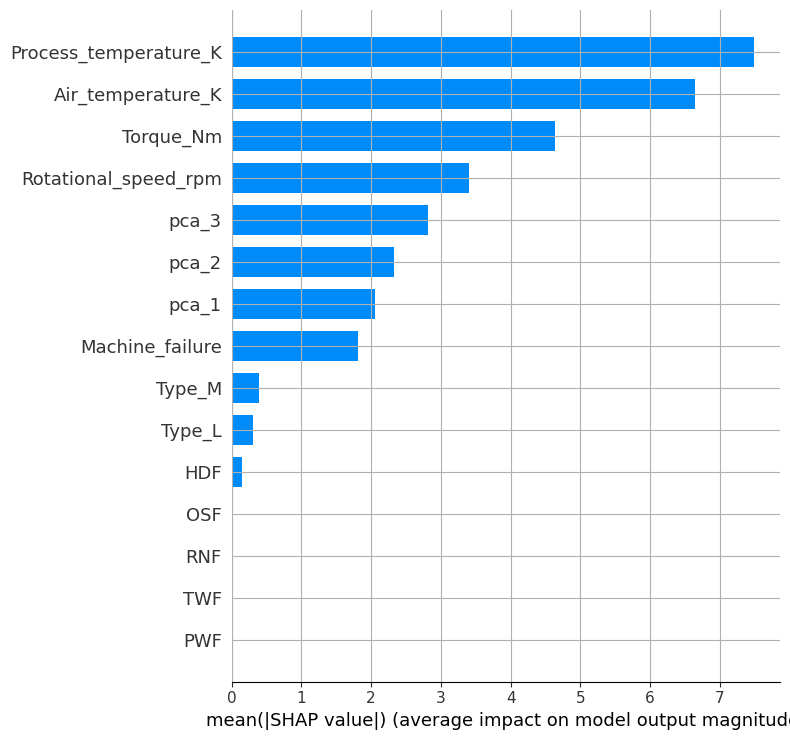

In [24]:
# Bar plot: 중요도 순으로만 보고 싶을 때
shap.summary_plot(
    shap_values_reg,
    X_valid_sample,
    feature_names=X_valid_sample.columns,
    plot_type="bar",
    show=True
)
